In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from scipy import stats
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
from pylab import rcParams
import matplotlib.pyplot as plt

In [2]:
def getFiles(file_list, which):
    datapath = "./../2022"
    for root, dirs, files in os.walk(datapath):
        for file in files:
            if ('csv' in file and not ("Movement" in file) and (file[0] == which)):
                file_list.append(os.path.join(root, file))
                
Thingy_list = []
Respect_list = []

getFiles(Thingy_list, 'T')
getFiles(Respect_list, 'R')

print(len(Thingy_list), len(Respect_list))

1014 1014


In [3]:
def all_csv_to_dataframe(dataframe, thingy_list, respect_list):
    for i in range(len(thingy_list)):
        thingy_file = thingy_list[i]
        respect_file = respect_list[i]
        if thingy_file[25:43] == respect_file[26:44]:
            
            new_thingy = pd.read_csv(thingy_file)
            new_thingy = new_thingy.rename(columns=
                             {'accel_x'      :'T_accel_x',
                              'accel_y'      :'T_accel_y',
                              'accel_z'      :'T_accel_z',
                              'gyro_x'       :'T_gyro_x' ,
                              'gyro_y'       :'T_gyro_y' ,
                              'gyro_z'       :'T_gyro_z' ,
                              'activity_code':'T_activity_code'})
            new_respect = pd.read_csv(respect_file)
            new_respect = new_respect.rename(columns=
                             {'accel_x'      :'R_accel_x',
                              'accel_y'      :'R_accel_y',
                              'accel_z'      :'R_accel_z',
                              'gyro_x'       :'R_gyro_x' ,
                              'gyro_y'       :'R_gyro_y' ,
                              'gyro_z'       :'R_gyro_z' ,
                              'activity_code':'R_activity_code'})
            
            new_dataframe = pd.concat([new_thingy, new_respect], axis=1)
            dataframe = pd.concat([dataframe, new_dataframe])
    dataframe = dataframe.dropna()
    return dataframe

dataframe = pd.DataFrame()
dataframe = all_csv_to_dataframe(dataframe, Thingy_list, Respect_list)

In [4]:
# Somehow there are 6873 and 664 null activity code/type in thingy and respect
print(dataframe['T_activity_code'].isnull().sum(), dataframe['R_activity_code'].isnull().sum())
dataframe = dataframe.dropna()
print(dataframe['T_activity_code'].isnull().sum(), dataframe['R_activity_code'].isnull().sum())

print(pd.unique(dataframe['T_activity_code']))
print(pd.unique(dataframe['R_activity_code']))

0 0
0 0
[ 12.  13.  31.   7.   2.   8.   6.  11.   5.   4.   0. 100.   1.]
[ 12.  13.  31.   7.   2.   8.   6.  11.   5.   4.   0. 100.   1.]


In [5]:
# Proof of all Thingy acitivy code are the same as all Respect activity code
not_same = dataframe['T_activity_code'] != dataframe['R_activity_code']
np.where(not_same)

(array([], dtype=int64),)

In [6]:
def create_dataset(dataframe, data_columns, label_column, time_steps=1, step=1):
    XX, YY = [], []
    raw_x = dataframe[data_columns]
    raw_y = dataframe[label_column]
    
    for i in range(0, len(raw_x) - time_steps, step):
        label = raw_y.iloc[i].values
        value = raw_x.iloc[i]
        same = True
        for j in range(i + 1, i + time_steps):
            if label != raw_y.iloc[j].values:
                same = False
                break
        if not same:
            continue
        else:
            value = raw_x.iloc[i: i + time_steps]
        XX.append(value)
        YY.append(label)
        
    X = np.array(XX)
    Y = np.array(YY)
    return X, Y

Thingy_columns = ['T_accel_x', 'T_accel_y', 'T_accel_z', 'T_gyro_x', 'T_gyro_y', 'T_gyro_z', 'mag_x', 'mag_y', 'mag_z']
Thingy_label = ['T_activity_code']
Respect_columns = ['R_accel_x', 'R_accel_y', 'R_accel_z', 'R_gyro_x', 'R_gyro_y', 'R_gyro_z']
Respect_label = ['R_activity_code']

In [10]:
# Thingy data only
X_Thingy, y_Thingy = create_dataset(dataframe, Thingy_columns, Thingy_label, 50, 10)
X_train_Thingy, X_test_Thingy, y_train_Thingy, y_test_Thingy = train_test_split(X_Thingy, y_Thingy, random_state=111)

encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
encoder = encoder.fit(y_train_Thingy)
y_train_Thingy = encoder.transform(y_train_Thingy)
y_test_Thingy  = encoder.transform(y_test_Thingy)
print(X_train_Thingy.shape, X_test_Thingy.shape, y_train_Thingy.shape, y_test_Thingy.shape)

(12864, 50, 9) (4289, 50, 9) (12864, 13) (4289, 13)


In [11]:
# Respect data only
X_Respect, y_Respect = create_dataset(dataframe, Respect_columns, Respect_label, 50, 10)
X_train_Respect, X_test_Respect, y_train_Respect, y_test_Respect = train_test_split(X_Respect, y_Respect, random_state=111)

encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
encoder = encoder.fit(y_train_Respect)
y_train_Respect = encoder.transform(y_train_Respect)
y_test_Respect  = encoder.transform(y_test_Respect)
print(X_train_Respect.shape, X_test_Respect.shape, y_train_Respect.shape, y_test_Respect.shape)

(12864, 50, 6) (4289, 50, 6) (12864, 13) (4289, 13)


In [7]:
# All data
X, y = create_dataset(dataframe, Thingy_columns + Respect_columns, Thingy_label, 50, 10)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=111)

encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
encoder = encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test  = encoder.transform(y_test)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(12864, 50, 15) (4289, 50, 15) (12864, 13) (4289, 13)


In [8]:
def create_model(X, y):
    n_timesteps, n_features, n_outputs = X.shape[1], X.shape[2], y.shape[1]
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(100, activation='relu'))
    model.add(tf.keras.layers.Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # train model
    model.fit(X, y, epochs=30, batch_size=32, verbose=1)
    return model

all_model = create_model(X_train, y_train)

Epoch 1/30
402/402 [==============================] - 3s 4ms/step - loss: 2.2287 - accuracy: 0.3957
Epoch 2/30
402/402 [==============================] - 2s 4ms/step - loss: 0.5536 - accuracy: 0.7827
Epoch 3/30
402/402 [==============================] - 2s 4ms/step - loss: 0.3087 - accuracy: 0.8843
Epoch 4/30
402/402 [==============================] - 2s 4ms/step - loss: 0.1881 - accuracy: 0.9316
Epoch 5/30
402/402 [==============================] - 2s 4ms/step - loss: 0.1330 - accuracy: 0.9531
Epoch 6/30
402/402 [==============================] - 2s 4ms/step - loss: 0.1083 - accuracy: 0.9625
Epoch 7/30
402/402 [==============================] - 2s 4ms/step - loss: 0.0721 - accuracy: 0.9769
Epoch 8/30
402/402 [==============================] - 2s 4ms/step - loss: 0.0642 - accuracy: 0.9788
Epoch 9/30
402/402 [==============================] - 2s 4ms/step - loss: 0.0810 - accuracy: 0.9761
Epoch 10/30
402/402 [==============================] - 2s 4ms/step - loss: 0.0598 - accuracy: 0.9806

In [12]:
respeck_model = create_model(X_train_Respect, y_train_Respect)
thingy_model = create_model(X_train_Thingy, y_train_Thingy)

Epoch 1/30
402/402 [==============================] - 8s 17ms/step - loss: 1.1314 - accuracy: 0.6037
Epoch 2/30
402/402 [==============================] - 6s 16ms/step - loss: 0.5355 - accuracy: 0.7820
Epoch 3/30
402/402 [==============================] - 7s 18ms/step - loss: 0.4174 - accuracy: 0.8350
Epoch 4/30
402/402 [==============================] - 6s 15ms/step - loss: 0.3579 - accuracy: 0.8616
Epoch 5/30
402/402 [==============================] - 7s 17ms/step - loss: 0.3033 - accuracy: 0.8829
Epoch 6/30
402/402 [==============================] - 7s 17ms/step - loss: 0.2762 - accuracy: 0.8907
Epoch 7/30
402/402 [==============================] - 7s 18ms/step - loss: 0.2373 - accuracy: 0.9115
Epoch 8/30
402/402 [==============================] - 7s 17ms/step - loss: 0.2023 - accuracy: 0.9213
Epoch 9/30
402/402 [==============================] - 6s 16ms/step - loss: 0.1763 - accuracy: 0.9334
Epoch 10/30
402/402 [==============================] - 7s 17ms/step - loss: 0.1750 - accura

In [15]:
respeck_results = respeck_model.evaluate(X_test_Respect, y_test_Respect, batch_size=32, verbose=0)
print("test loss, test acc:", respeck_results)

thingy_results = thingy_model.evaluate(X_test_Thingy, y_test_Thingy, batch_size=32, verbose=0)
print("test loss, test acc:", thingy_results)

all_results = all_model.evaluate(X_test, y_test, batch_size=32, verbose=0)
print("test loss, test acc:", all_results)

test loss, test acc: [0.3292960822582245, 0.9333177804946899]
test loss, test acc: [0.09525217860937119, 0.9678246974945068]
test loss, test acc: [0.019712837412953377, 0.9939379692077637]


135/135 [==============================] - 1s 4ms/step


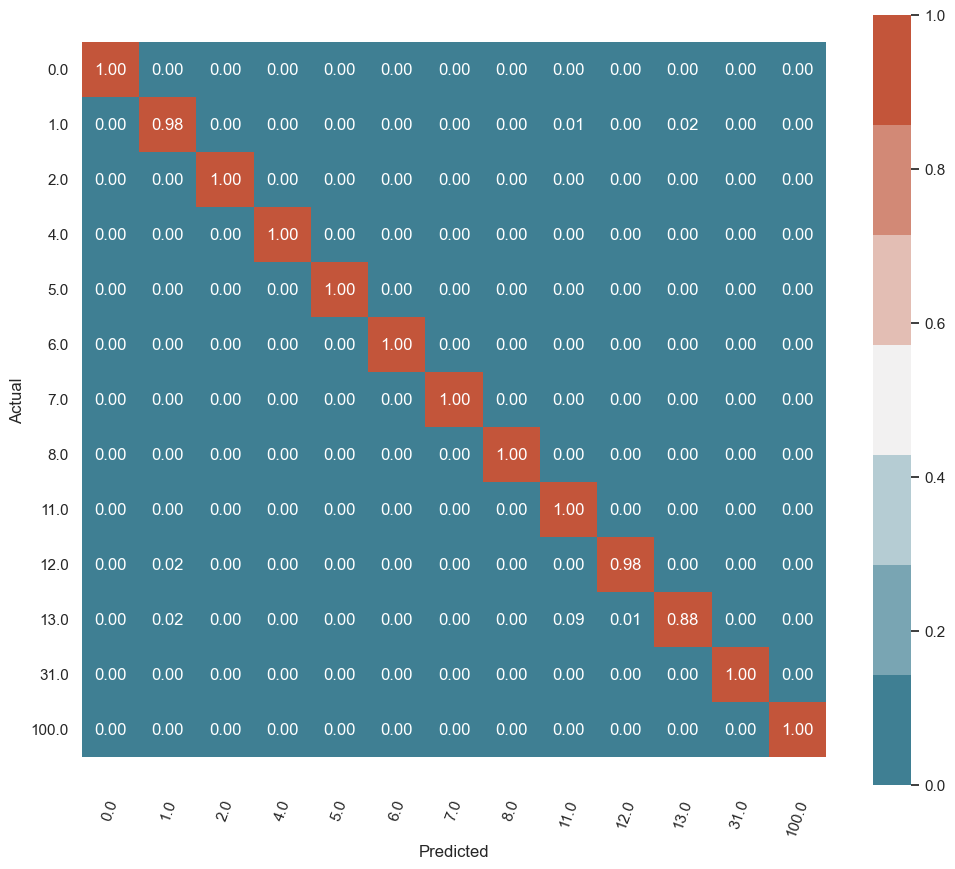

In [27]:
predy = all_model.predict(X_test)
# print(predy)
def plot_cm(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    fig, ax = plt.subplots(figsize=(12, 10)) 
    ax = sns.heatmap(
        cm, 
        annot=True, 
        fmt=".2f", 
        cmap=sns.diverging_palette(220, 20, n=7),
        ax=ax
    )

    plt.xticks(rotation=70)
    plt.yticks(rotation=90)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names, rotation=0)
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1)

rcParams['figure.figsize'] = 22, 10

plot_cm(
    encoder.inverse_transform(y_test),
    encoder.inverse_transform(predy),
    encoder.categories_[0]
) 

In [9]:
# all model
all_converter = tf.lite.TFLiteConverter.from_keras_model(all_model)
tflite_all_model = all_converter.convert()

with open('all_model.tflite', 'wb') as f:
  f.write(tflite_all_model)

INFO:tensorflow:Assets written to: C:\Users\minsu\AppData\Local\Temp\tmpa1g7a5xs\assets


INFO:tensorflow:Assets written to: C:\Users\minsu\AppData\Local\Temp\tmpa1g7a5xs\assets


In [13]:
# respeck model
respeck_converter = tf.lite.TFLiteConverter.from_keras_model(respeck_model)
tflite_respeck_model = respeck_converter.convert()

with open('respeck_model.tflite', 'wb') as f:
  f.write(tflite_respeck_model)

INFO:tensorflow:Assets written to: C:\Users\minsu\AppData\Local\Temp\tmpwbk_h6tb\assets


INFO:tensorflow:Assets written to: C:\Users\minsu\AppData\Local\Temp\tmpwbk_h6tb\assets


In [14]:
# thingy model
thingy_converter = tf.lite.TFLiteConverter.from_keras_model(thingy_model)
tflite_thingy_model = thingy_converter.convert()

with open('thingy_model.tflite', 'wb') as f:
  f.write(tflite_thingy_model)

INFO:tensorflow:Assets written to: C:\Users\minsu\AppData\Local\Temp\tmpnq67sp1n\assets


INFO:tensorflow:Assets written to: C:\Users\minsu\AppData\Local\Temp\tmpnq67sp1n\assets
